# Install Requirements

Import Huggingface modules

In [ ]:
# Install necessary libraries
!pip install transformers datasets evaluate accelerate scikit-learn pandas

In [ ]:
%%writefile requirements.txt
transformers
datasets
evaluate
accelerate

Overwriting requirements.txt


In [ ]:
! pip install -r requirements.txt

In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import torch

In [ ]:
# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Data Load and Preprocess

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the dataset
train = pd.read_csv("/content/drive/MyDrive/Text_Mining/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Text_Mining/test.csv")

In [ ]:
train.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


# Pre-Processing

Rename Column Class Index

In [ ]:
# Rename the 'Class Index' class for more consistency
train.rename(columns={'Class Index': 'labels'}, inplace=True)
test.rename(columns={'Class Index': 'labels'}, inplace=True)

# ----> Check and adjust the labels to be in the range 0-3 <----
train['labels'] = train['labels'] - 1
test['labels'] = test['labels'] - 1
train.head()

,labels,Title,Description
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Concatenate Column Title and Description into 'text'

In [ ]:
# concatinating the 'title' and 'description' column as 'text'
train['text']=(train['Title']+train['Description'])
train.drop(columns=['Title','Description'],axis=1,inplace=True)
train.head()

# concatinating the 'title' and 'description' column as 'text'
test['text']=(test['Title']+test['Description'])
test.drop(columns=['Title','Description'],axis=1,inplace=True)
test.head()

,labels,text
0,2,Fears for T N pension after talksUnions repres...
1,3,The Race is On: Second Private Team Sets Launc...
2,3,Ky. Company Wins Grant to Study Peptides (AP)A...
3,3,Prediction Unit Helps Forecast Wildfires (AP)A...
4,3,Calif. Aims to Limit Farm-Related Smog (AP)AP ...


Check for Missing values

In [ ]:
train.isnull().sum()

,0
labels,0
text,0


In [ ]:
test.isnull().sum()

,0
labels,0
text,0


Check for duplicated rows

In [ ]:
train.duplicated().sum()

0

In [ ]:
test.duplicated().sum()

0

Display number of rows and columns

In [ ]:
train_shape = train.shape
test_shape = test.shape

print(f"Train Number of rows and columns: {train_shape}")
print(f"Test Number of rows and columns: {test_shape}")

Train Number of rows and columns: (120000, 2)
Test Number of rows and columns: (7600, 2)


Check if the classes are balanced

In [ ]:
train_class_distribution = train['labels'].value_counts(normalize=True)
test_class_distribution = test['labels'].value_counts(normalize=True)

print("Training Set Class Distribution:")
print(train_class_distribution)

print("\nTest Set Class Distribution:")
print(test_class_distribution)

Training Set Class Distribution:
labels
2    0.25
3    0.25
1    0.25
0    0.25
Name: proportion, dtype: float64

Test Set Class Distribution:
labels
2    0.25
3    0.25
1    0.25
0    0.25
Name: proportion, dtype: float64


## Split the training set

In [ ]:
# Split the Training Data into Training and Validation Sets
train_data, val_data = train_test_split(train, test_size=0.3, random_state=42)

# Tokenization

In [ ]:
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Convert Pandas DataFrames to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch tensors
train_dataset = train_dataset.with_format("torch")
val_dataset = val_dataset.with_format("torch")
test_dataset = test_dataset.with_format("torch")

Map:   0%|          | 0/84000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

# Model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define Evaluation Metrics
def compute_metrics(pred):
    predictions, labels = pred
    predictions = predictions.argmax(axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    optim='adamw_torch',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# Train the Model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.142100,0.211257,0.932806,0.933122
2,0.068500,0.193051,0.947083,0.947142
3,0.081700,0.229840,0.946139,0.946131


TrainOutput(global_step=15750, training_loss=0.15812309803399774, metrics={'train_runtime': 11450.3584, 'train_samples_per_second': 22.008, 'train_steps_per_second': 1.376, 'total_flos': 6.6305176584192e+16, 'train_loss': 0.15812309803399774, 'epoch': 3.0})

# Visualization

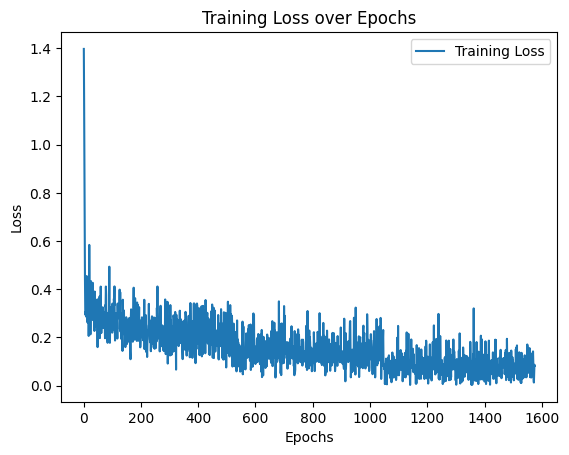

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss
training_loss = trainer.state.log_history
# Filter out entries that don't contain the 'loss' key
loss_entries = [entry for entry in training_loss if 'loss' in entry]
epochs = range(1, len(loss_entries) + 1) # adjust epochs range to training loss values

plt.plot(epochs, [entry['loss'] for entry in loss_entries], label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

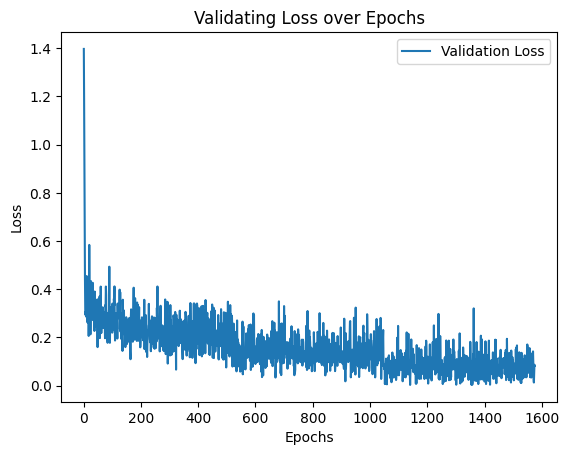

In [ ]:
import matplotlib.pyplot as plt

# Plot validation loss
validation_loss = trainer.state.log_history
# Filter out entries that don't contain the 'loss' key
loss_entries = [entry for entry in validation_loss if 'loss' in entry]
epochs = range(1, len(loss_entries) + 1) # adjust epochs range to training loss values

plt.plot(epochs, [entry['loss'] for entry in loss_entries], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validating Loss over Epochs")
plt.legend()
plt.show()

# Evaluation

In [ ]:
# Evaluate on the Test Set
test_results = trainer.evaluate(test_dataset)

print("Final Test Set Performance:")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")

Final Test Set Performance:
Accuracy: 0.9474
F1 Score: 0.9475


In [ ]:
from sklearn.metrics import classification_report

# Get predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = predictions.predictions.argmax(axis=1)

# True labels
true_labels = predictions.label_ids

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['World', 'Sports', 'Business', 'Sci/Tech'])
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       World       0.97      0.95      0.96      1900
      Sports       0.99      0.99      0.99      1900
    Business       0.92      0.92      0.92      1900
    Sci/Tech       0.91      0.93      0.92      1900

    accuracy                           0.95      7600
   macro avg       0.95      0.95      0.95      7600
weighted avg       0.95      0.95      0.95      7600



## Save the model

In [ ]:
# Save the model and tokenizer
trainer.save_model("/content/drive/MyDrive/Text_Mining/BERT_Text_classification")  # Saves the model
tokenizer.save_pretrained("/content/drive/MyDrive/Text_Mining/BERT_Text_classification")  # Saves the tokenizer
print("Model and tokenizer saved successfully.")

Model and tokenizer saved successfully.


# Test Model with Custom Article

In [3]:
def test_model(custom_article):
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    import torch

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # Tokenize and prepare the input
    inputs = tokenizer(
        custom_article,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )

    # Load the model # This line is crucial. You need to load your model here
    model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Text_Mining/BERT_Text_classification")

    model.eval() # Now this line will work as model is defined
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predictions
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    # Map predictions to labels
    label_map = {
        0: "World",
        1: "Sports",
        2: "Business",
        3: "Sci/Tech"
    }
    predicted_label = label_map[predictions.item()]

    print(f"This article is a {predicted_label} article")

# Example usage
custom_article = (
    "The research team, having meticulously collected data from a variety of sources, including satellite imagery, "
    "on-the-ground surveys, and historical climate records, analyzed the impacts of urbanization on local ecosystems, "
    "revealing significant correlations between increased development and the decline of biodiversity, which necessitated "
    "immediate action to mitigate further damage."
)

test_model(custom_article)

This article is a Sci/Tech article
